# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars due to lane misalignment.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 4 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

# Calibration And Undistortion

## Camera Calibration

The first step we will take is to find the calibration matrix, along with distortion coefficient for the camera that was used to take pictures of the road. This is necessary because the convex shape of camera lenses curves light rays as the enter the pinhole, therefore causing distortions to the real image. Therefore lines that are straight in the real world may not be anymore on our photos. 

To compute the camera the transformation matrix and distortion coefficients, we use a multiple pictures of a _chessboard_ on a flat surface taken **by the same camera**. OpenCV has a convenient method called [findChessboardCorners](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) that will identify the points where black and white squares intersect and reverse engineer the distorsion matrix this way. 

**ADD IMAGE OF PINHOLE MODEL**

**ADD IMAGE OF CHESSBOARD CORNERS FINDING**

In [1]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

In [3]:
def load_image(path, to_rgb=True):
    img = cv2.imread(path)
    return img if not to_rgb else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to show us a list of traffic sign images
    """
    #img_count = len(img_list)
    #rows = img_count // cols
    rows = len(img_list)
    cmap = None
    
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, rows):
        for j in range(0, cols):
            ax = axes[i, j] if rows > 1 else axes[j]
            #k = i * cols + j
            img_name = img_labels[i][j]   
            img = img_list[i][j]
            if len(img.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"
                img = np.reshape(img, (img.shape[0], img.shape[1]))

            if not show_ticks:            
                ax.axis("off")

            ax.imshow(img, cmap=cmap)
            ax.set_title(img_name)
                
    fig.suptitle(title, fontsize=12, fontweight='bold', y = 1)
    fig.tight_layout()
    plt.show()
    
    return

### Finding Chessboard Corners

We must determine the number of inner corners horizontally and vertically for our sample chessboard pictures.

In [5]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

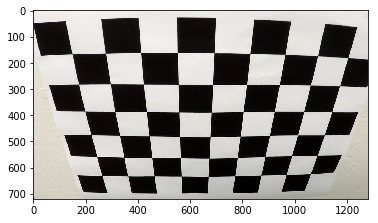

In [6]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

Our chessboard has *9* inner corners in the x direction, and *6* in the y direction. We will use these as parameters to *findChessboardCorners()*.

In [7]:
cx = 9
cy = 6

We submit grayscale images to _findChessboardCorners_ so we must therefore define a utility method for this purpose.

In [8]:
def to_grayscale(img):
    """
    Returns the grayscaled version of the supplied image (in RGB format)
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [9]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [10]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

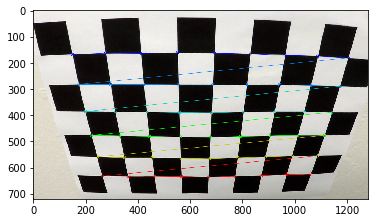

In [11]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

### Image Undistortion

#### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [12]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [13]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [14]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [15]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [16]:
test_img_path = test_imgs_paths[5]
test_img = load_image(test_img_path)

In [17]:
undistorted_test_img = undistort_image(test_img, opts, ipts)

In [18]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [19]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [20]:
undist_test_img_names

array(['undistorted_straight_lines1', 'undistorted_straight_lines2',
       'undistorted_test1', 'undistorted_test2', 'undistorted_test3',
       'undistorted_test4', 'undistorted_test5', 'undistorted_test6'],
      dtype='<U27')

In [21]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

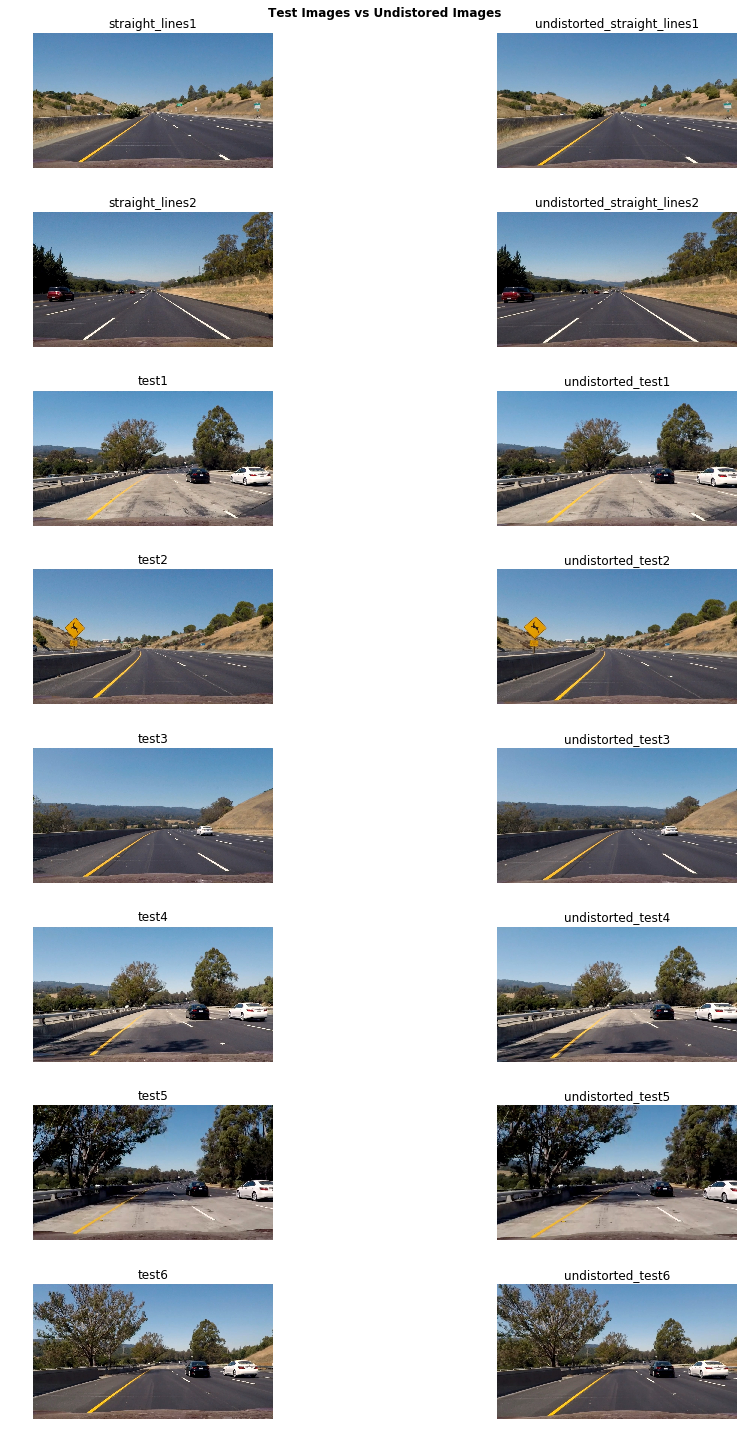

In [22]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(15, 20), cols=2, show_ticks=False)

The sample above shows original next to undistored images.

## Thresholding

We apply edge and color thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later.

### Gradient Thresholding Via Sobel

We use the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) operator to identify _gradients_, that is change in _color intensity_ in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

#### Sobel In X or Y Directions

In [23]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [24]:
undist_test_img_gray = to_grayscale(undistorted_test_img)

In [25]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [26]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

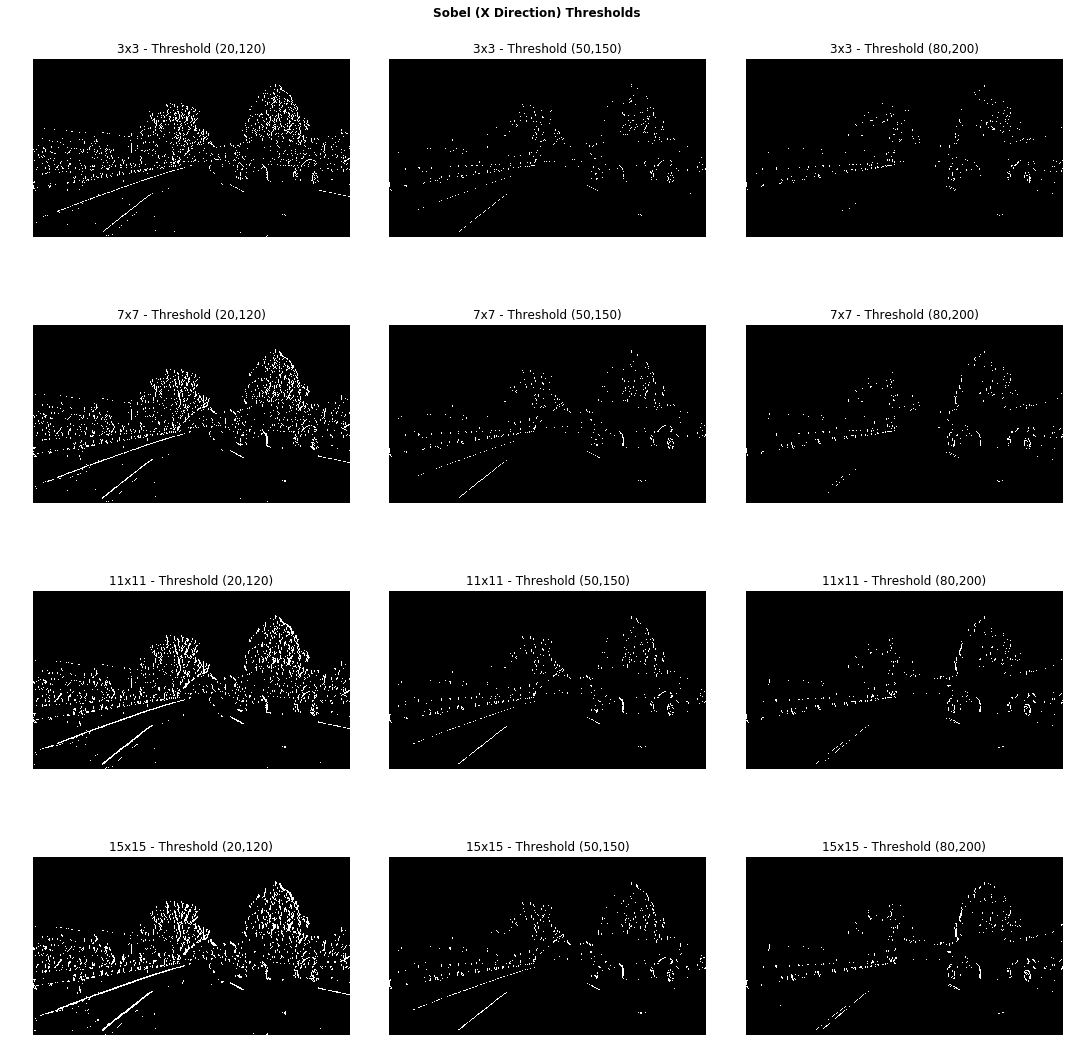

In [27]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [28]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

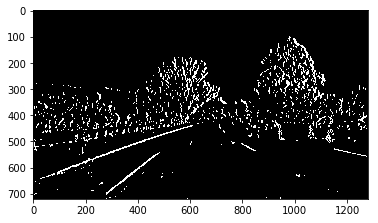

In [29]:
plt.imshow(sobx_best, cmap='gray')

In [30]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [31]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

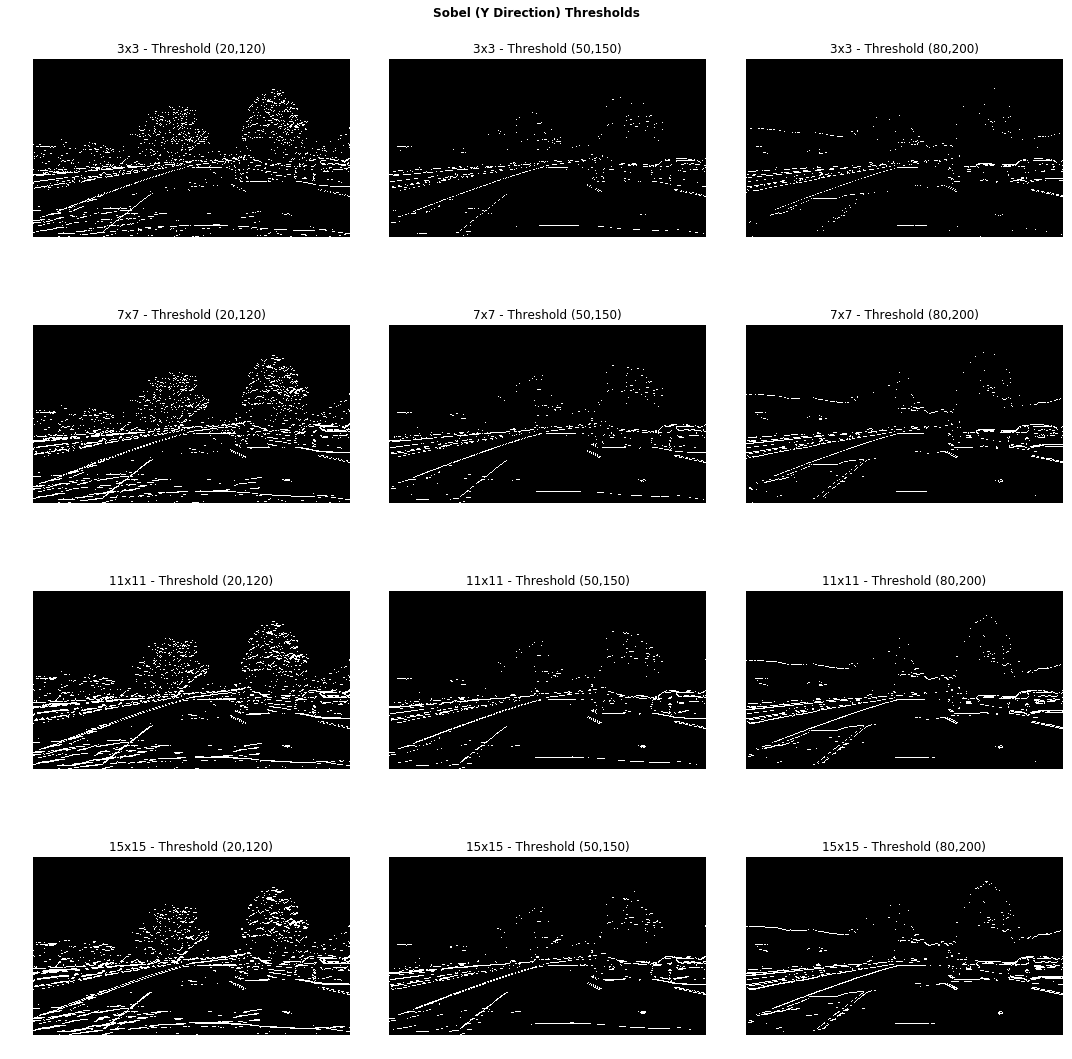

In [32]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [33]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

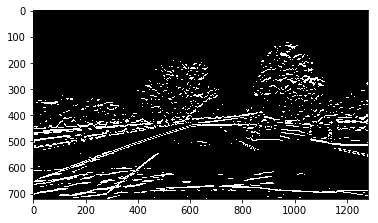

In [34]:
plt.imshow(soby_best, cmap='gray')

#### Sobel Magnitude in X and Y Directions

In [35]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [36]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [37]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


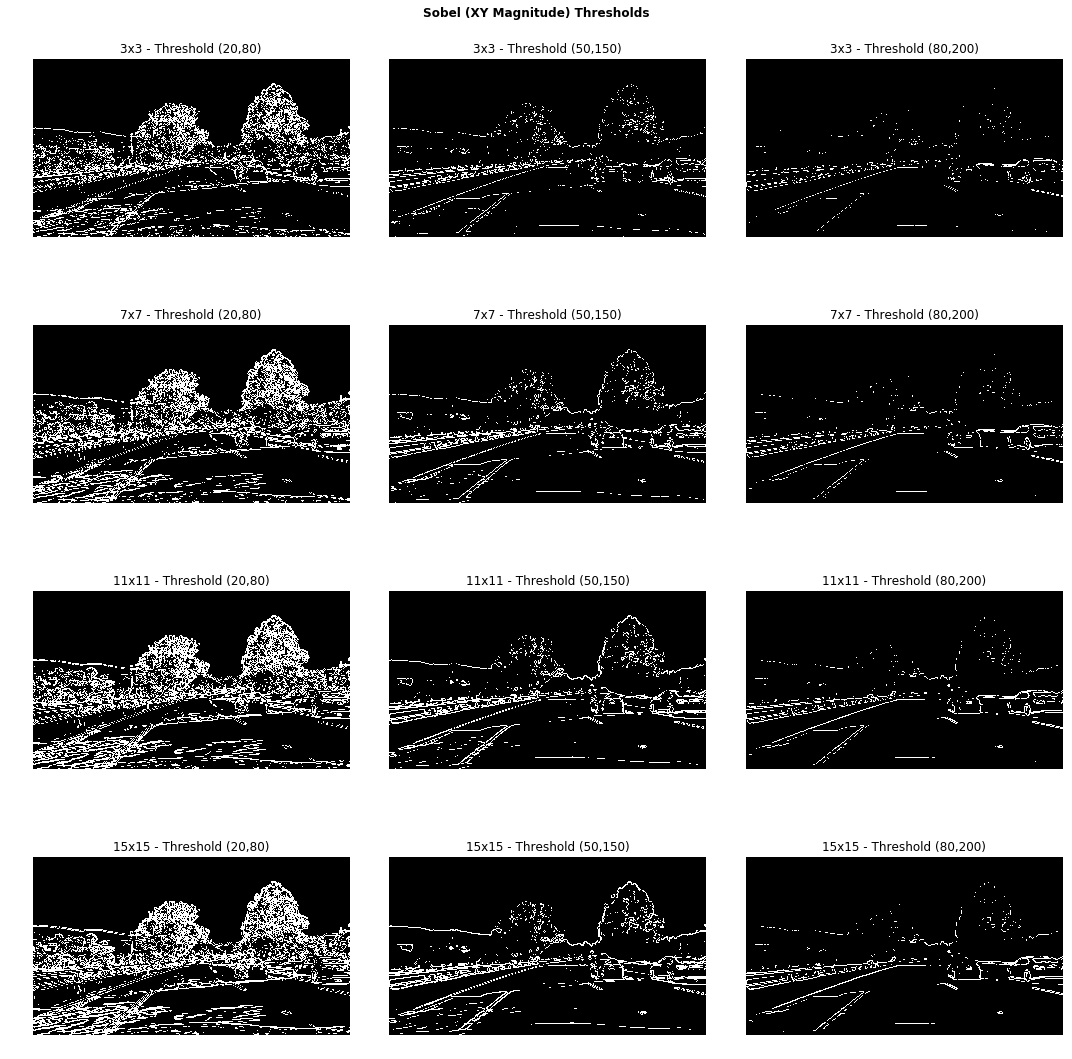

In [38]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[80, 200]_ and kernel size 15.

In [39]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

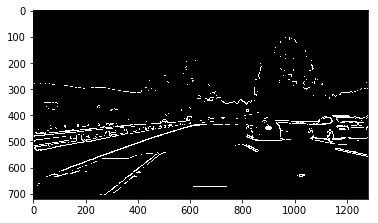

In [40]:
plt.imshow(sobxy_best, cmap='gray')

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [41]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [243]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels
    #combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    #combined[((sx_binary == 1)) | ((sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    combined[(sx_binary == 1) | ((sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    return combined

In [43]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [44]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [45]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))



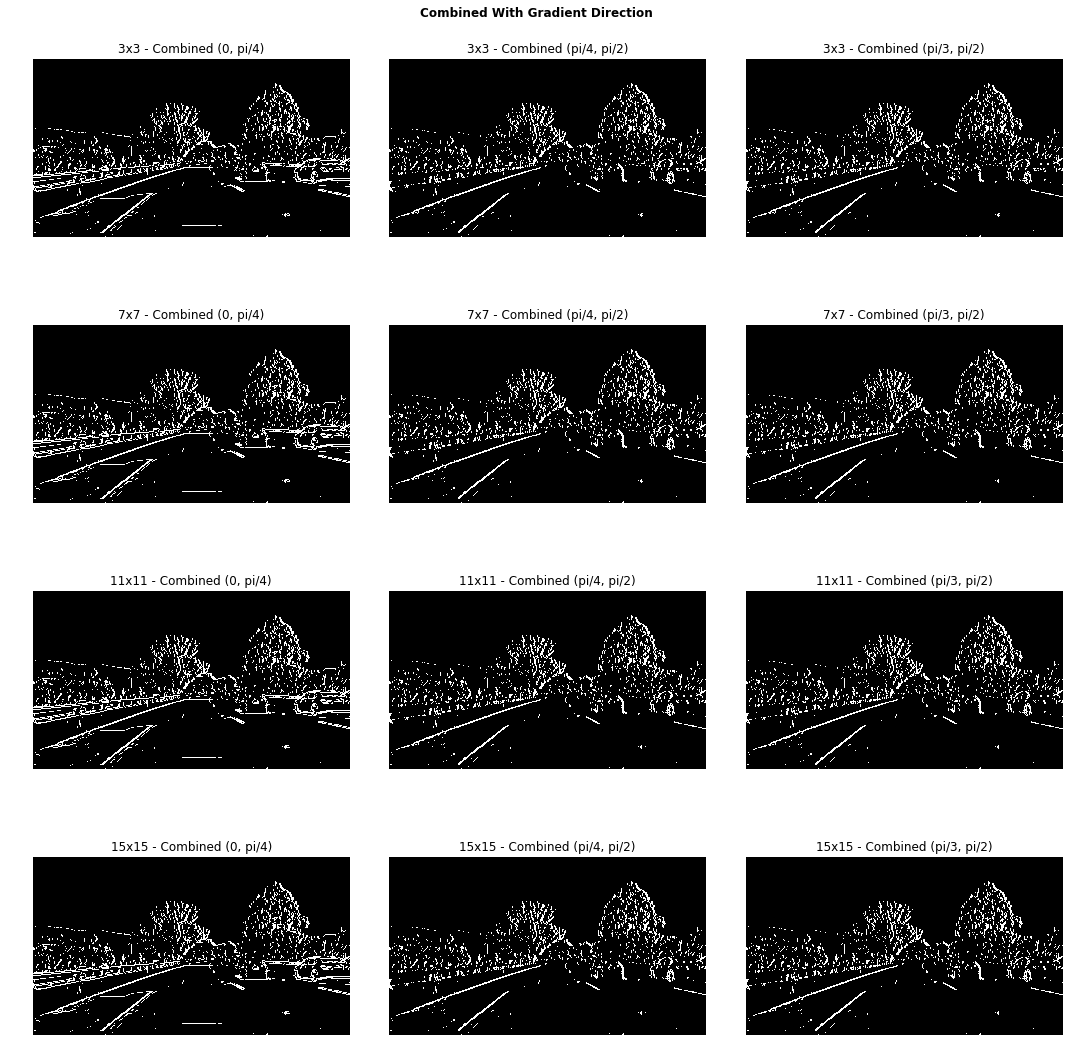

In [46]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval _[pi/4, pi/2]_ as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [47]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

The resulting image from combined variant of sobel operations shows promise. However, we can see that some lanes are not fully identified, due to shadows obscuring the image. We turn to color space manipulation in order to better isolate the yellow and white lines.

### Color Thresholding

We experiment with different color spaces and try out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [48]:
def to_hsv(img):
    """
    Returns the same image in HSV format
    The input image must be in RGB format
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    

In [49]:
def to_hls(img):
    """
    Returns the same image in HLS format
    The input image must be in RGB format
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [50]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [51]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [52]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [53]:
hsv_test_img = to_hsv(undist_test_imgs[7])
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [54]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs))

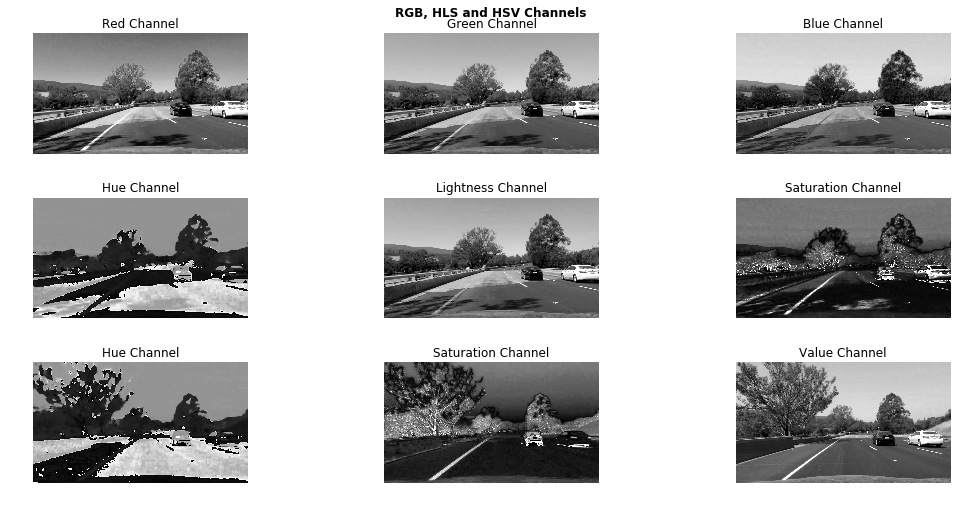

In [55]:
show_image_list(color_spaces_comps, color_spaces_lbs, "RGB, HLS and HSV Channels", cols=3, fig_size=(15, 7), show_ticks=False)

On the RGB components, we see that the blue channel gives the least clarity on the lines, while the red channel seems to give best results.

For HSL, the hue channel produces an extremely noisy output, while the saturation channel seems to give the best results. **The saturation channel in fact seems to produce the best contrast** so we will therefore focus on trying different thresholds for this channel.

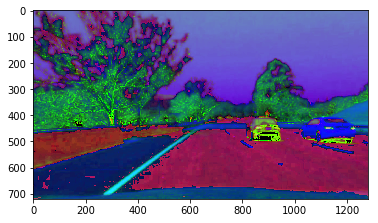

In [56]:
plt.imshow(hsv_test_img)

In [57]:
hsv_test_img_bin = np.zeros_like(hsv_test_img[:,:,0])
hsv_test_img_bin[(hsv_test_img[:,:,0] >= 15) & (hsv_test_img[:,:,0] <= 35) ] = 1

#hsv_test_img_bin2 = np.zeros_like(hsv_test_img[:,:,0])
#hsv_test_img_bin2[(hsv_test_img[:,:,0] >= 28) & (hsv_test_img[:,:,0] <= 43) ] = 1

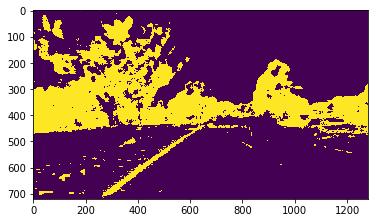

In [58]:
plt.imshow(hsv_test_img_bin)

In [59]:
hsv_h_thres_1 = np.asarray([[threshold_img(hlv_test_img, 0, thres=(0, 85)), threshold_img(hls_test_img, 2, thres=(85, 170)), threshold_img(hls_test_img, 2, thres=(170, 255))]])
hsv_h_lbs_1 = np.asarray([["S Thresold (0,85)", "S Thresold (85,170)", "S Thresold (170,255)"]])

hls_s_thres_2 = np.asarray([[threshold_img(hls_test_img, 2, thres=(50, 100)), threshold_img(hls_test_img, 2, thres=(100, 150)), threshold_img(hls_test_img, 2, thres=(150, 255))]])
hls_s_lbs_2 = np.asarray([["S Thresold (50,100)", "S Thresold (100,150)", "S Thresold (150,255)"]])

NameError: name 'hlv_test_img' is not defined

In [60]:
hls_s_thres = np.concatenate((hls_s_thres_1, hls_s_thres_2))
hls_s_lbs = np.concatenate((hls_s_lbs_1, hls_s_lbs_2))

NameError: name 'hls_s_thres_1' is not defined

In [61]:
show_image_list(hls_s_thres, hls_s_lbs, "HLS - S Thresholds", cols=3, fig_size=(15, 7), show_ticks=False)

NameError: name 'hls_s_thres' is not defined

In [62]:
hls_test_img = to_hls(undist_test_imgs[7])

In [63]:
hls_test_img_yellow_bin = np.zeros_like(hls_test_img[:,:,0])
hls_test_img_yellow_bin[((hls_test_img[:,:,0] >= 15) & (hls_test_img[:,:,0] <= 35))
                 & ((hls_test_img[:,:,1] >= 38) & (hls_test_img[:,:,1] <= 204))
                 & ((hls_test_img[:,:,2] >= 115) & (hls_test_img[:,:,2] <= 255))                
                ] = 1


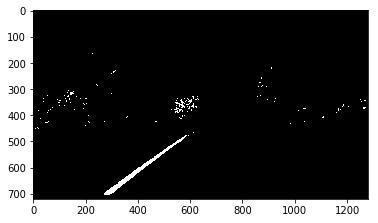

In [64]:
plt.imshow(hls_test_img_yellow_bin, cmap='gray')

In [67]:
 low_threshold = np.array([0, 200, 0], dtype=np.uint8)
    # Higher value equivalent pure HSL is (360, 100, 100)
high_threshold = np.array([180, 255, 255], dtype=np.uint8)  

In [68]:
hls_test_img_white_bin = np.zeros_like(hls_test_img[:,:,0])
hls_test_img_white_bin[((hls_test_img[:,:,0] >= 0) & (hls_test_img[:,:,0] <= 255))
                 & ((hls_test_img[:,:,1] >= 200) & (hls_test_img[:,:,1] <= 255))
                 & ((hls_test_img[:,:,2] >= 0) & (hls_test_img[:,:,2] <= 255))                
                ] = 1


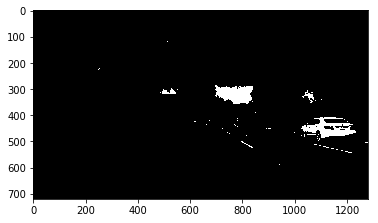

In [69]:
plt.imshow(hls_test_img_white_bin, cmap='gray')

In [70]:
hls_test_white_yellow_bin = np.zeros_like(hls_test_img_white_bin)
hls_test_white_yellow_bin[(hls_test_img_yellow_bin == 1) | (hls_test_img_white_bin == 1)] = 1

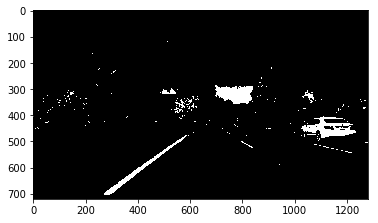

In [71]:
plt.imshow(hls_test_white_yellow_bin, cmap='gray')

In [328]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

In [ ]:
best_hls = compute_hls_white_yellow_binary(undist_test_imgs[1])
plt.imshow(best_hls, cmap='gray')

In [ ]:
plt.imshow(undist_test_imgs[1])

In [ ]:
low_threshold = np.array([15, 38, 115], dtype=np.uint8)
    # Higher value equivalent pure HSL is (75, 100, 80)
high_threshold = np.array([35, 204, 255], dtype=np.uint8)  

In [ ]:
hls_s_thres_1 = np.asarray([[threshold_img(hls_test_img, 2, thres=(0, 85)), threshold_img(hls_test_img, 2, thres=(85, 170)), threshold_img(hls_test_img, 2, thres=(170, 255))]])
hls_s_lbs_1 = np.asarray([["S Thresold (0,85)", "S Thresold (85,170)", "S Thresold (170,255)"]])

hls_s_thres_2 = np.asarray([[threshold_img(hls_test_img, 2, thres=(50, 100)), threshold_img(hls_test_img, 2, thres=(100, 150)), threshold_img(hls_test_img, 2, thres=(150, 255))]])
hls_s_lbs_2 = np.asarray([["S Thresold (50,100)", "S Thresold (100,150)", "S Thresold (150,255)"]])


In [ ]:
hls_s_thres = np.concatenate((hls_s_thres_1, hls_s_thres_2))
hls_s_lbs = np.concatenate((hls_s_lbs_1, hls_s_lbs_2))

In [ ]:
show_image_list(hls_s_thres, hls_s_lbs, "HLS - S Thresholds", cols=3, fig_size=(15, 7), show_ticks=False)


We seem to obtain the best results with thresholding on the saturation channel with values in the interval _[150,255]_. We will use this interval going forward.

In [ ]:
hls_s_binary_best = threshold_img(hls_test_img, 2, thres=(150, 255))

### Combining Color And Gradient (Sobel) Thresholds

In [77]:
color_binary = np.dstack((np.zeros_like(hls_s_binary_best), sobel_combined_best, hls_s_binary_best)) * 255
color_binary = color_binary.astype(np.uint8)

NameError: name 'hls_s_binary_best' is not defined

In [ ]:
combined_binary = np.zeros_like(hls_s_binary_best)
combined_binary[(sobel_combined_best == 1) | (hls_s_binary_best == 1)] = 1

In [ ]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined S And Gradient Thresholds"]])

In [ ]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=True)

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

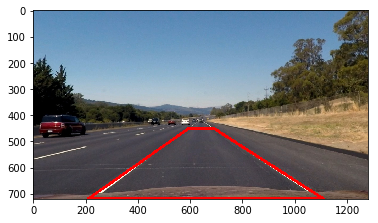

In [78]:
#pts = np.array([[250,bottom_px],[600,450],[700,450], [1180, bottom_px]], np.int32)
#pts = np.array([[200,bottom_px],[520,500],[770,500], [1120, bottom_px]], np.int32)
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.imshow(copy_combined)

In [79]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [80]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [81]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [82]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

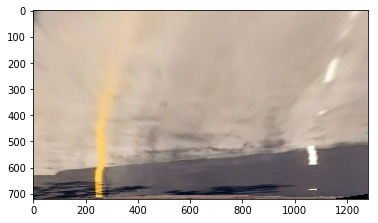

In [83]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [84]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

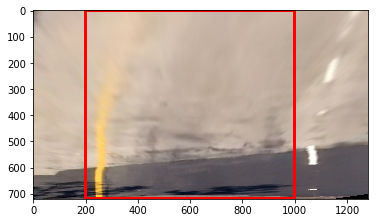

In [85]:
test_persp_img = np.copy(test_imgs_pers_tr[5])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)
plt.imshow(test_persp_img)

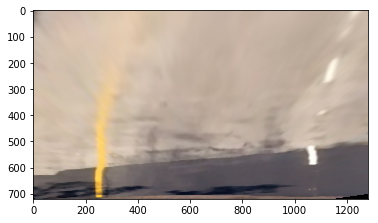

In [86]:
plt.imshow(cv2.medianBlur(test_imgs_pers_tr[5], 9))

We can see that our perspective transform keeps straight lines straight, which is a required sanity check.

In [89]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

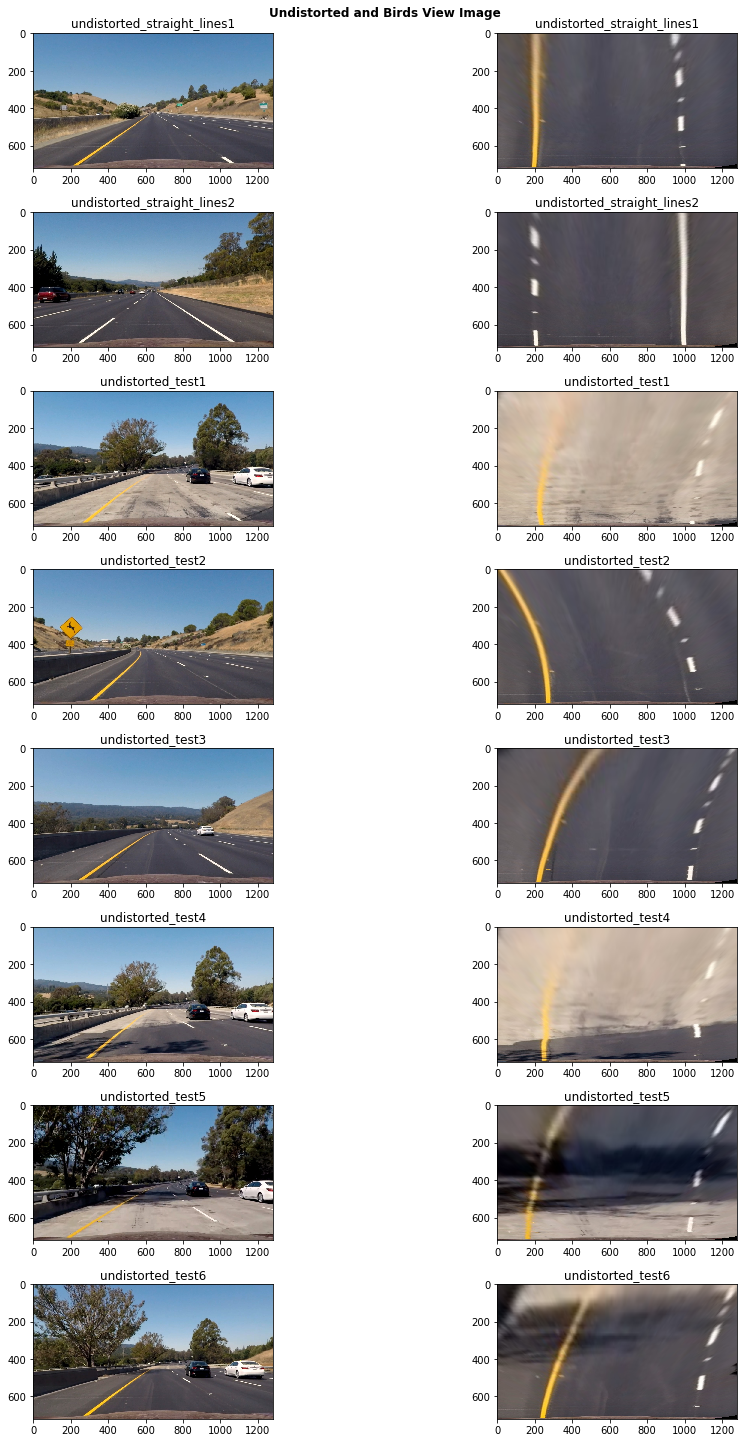

In [268]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

At this stage it is fitting to start definining a pipeline of operations to perform and visualise perspective transform on thresholding binary images.

In [272]:
test_hls_psp_tr = to_hls(test_undist_imgs_and_p_tr[6][1])

In [318]:
test_hls_psp_tr[400,200]

array([ 20, 114,  36], dtype=uint8)

In [320]:
hls_w_h_test_psp_tr = compute_hls_white_yellow_binary(test_undist_imgs_and_p_tr[6][1])
#plt.imshow(test_hls_psp_tr[:,:,2])

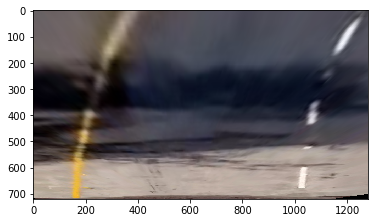

In [321]:
plt.imshow(test_undist_imgs_and_p_tr[6][1])

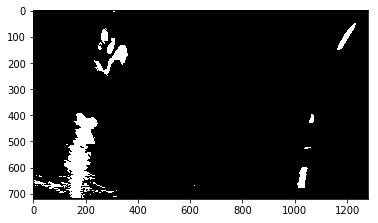

In [322]:
plt.imshow(hls_w_h_test_psp_tr, cmap='gray')

In [274]:
lab_test = cv2.cvtColor(test_undist_imgs_and_p_tr[6][1], cv2.COLOR_RGB2LAB)

In [275]:
lab_test.shape

(720, 1280, 3)

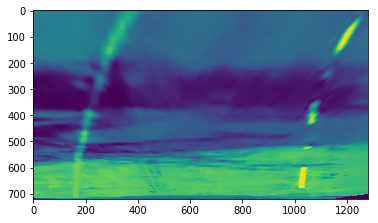

In [276]:
plt.imshow(lab_test[:,:,0])

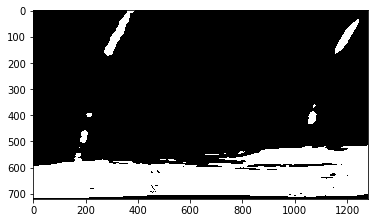

In [310]:
lab_thres = np.zeros_like(lab_test[:,:,0])
lab_thres[(lab_test[:,:,0] >= 150)] = 1
plt.imshow(lab_thres, cmap='gray')

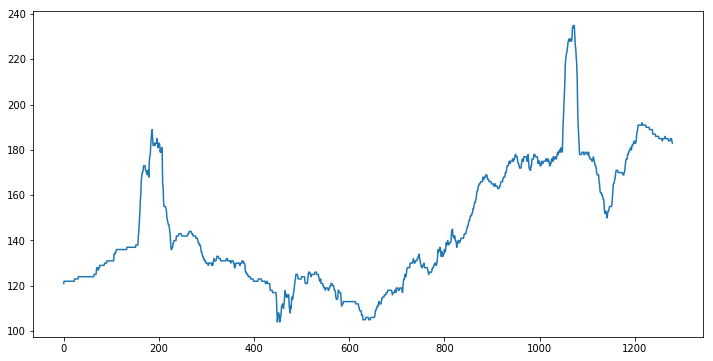

In [311]:
histogram = np.sum(lab_thres[lab_thres.shape[0]//2:,:], axis=0)
plt.figure(figsize=(12,6))
plt.plot(histogram)

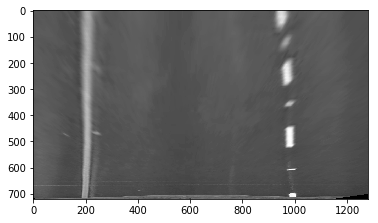

In [93]:
test_hls_l_psp_tr = test_hls_psp_tr[:,:,1]
plt.imshow(test_hls_l_psp_tr, cmap='gray')

In [119]:
blur_test = cv2.GaussianBlur(test_hls_l_psp_tr,(15,15),0)


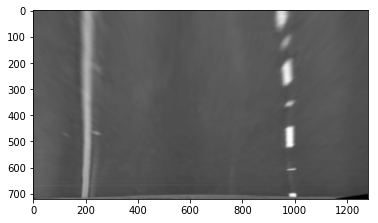

In [120]:
plt.imshow(blur_test, cmap='gray')

In [341]:
def get_combined_binary_thresholded_img(undist_img, with_clahe=False, with_blur=False):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    #undist_img_gray = to_grayscale(undist_img)
    #undist_img_gray = to_hsv(undist_img)[:,:,2]
    undist_img_gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2LAB)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 150))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(80, 150))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 150))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    #undist_img_hls = to_hls(undist_img)
    #hls_s_thresholds = threshold_img(undist_img_hls, 2, thres=(150, 255))
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    #undist_img_hsv = to_hsv(undist_img)
    #hsv_img_thres = np.zeros_like(undist_img_hsv[:,:,0])
    #hsv_img_thres[(undist_img_hsv[:,:,0] >= 15) & (undist_img_hsv[:,:,0] <= 35) ] = 1

    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
    
    if with_clahe:        
        clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=100.0)
        combined_binary = clahe.apply(combined_binary)
    #plt.imshow(cl1, cmap='gray')
    
    if with_blur:
        combined_binary = cv2.medianBlur(combined_binary,5)
    
    return combined_binary

In [342]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [343]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [344]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [345]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

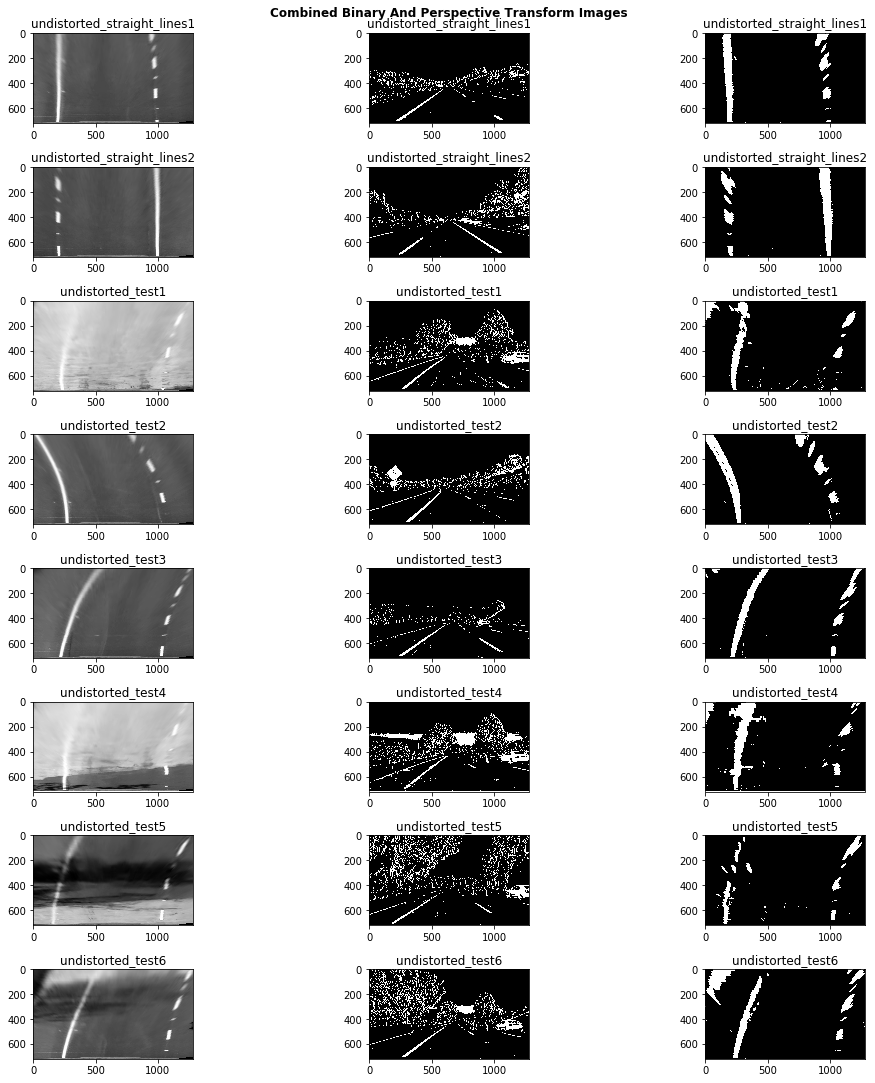

In [346]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

The perspective transform still works reasonably well but we are faced with lots of artefacts on the image.

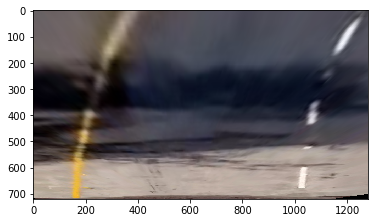

In [334]:
plt.imshow(test_imgs_psp_tr[-2])

In [195]:
lab_test = cv2.cvtColor(test_imgs_psp_tr[-2], cv2.COLOR_RGB2LAB)[:,:,0]

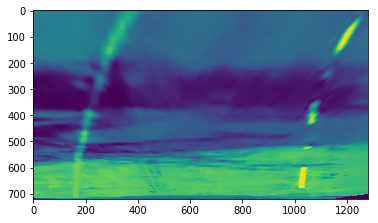

In [196]:
plt.imshow(lab_test)

In [208]:
sx = abs_sobel(lab_test, kernel_size=15, thres=(30, 150))
sy = abs_sobel(lab_test, x_dir=False, kernel_size=15, thres=(50, 150))
sxy = mag_sobel(lab_test, kernel_size=15, thres=(20, 200))


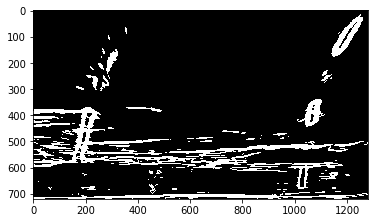

In [210]:
plt.imshow(sxy, cmap='gray')

In [162]:
sample_combined_binary_psp_tr = test_imgs_combined_binary_psp_tr[7]

In [163]:
sample_combined_binary_psp_tr[sample_combined_binary_psp_tr.shape[0]//2:,:].shape

(360, 1280)

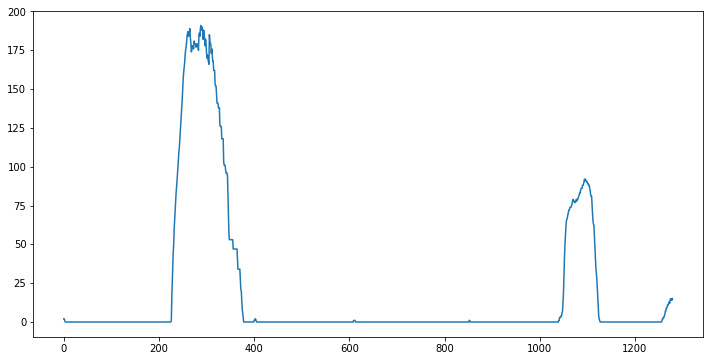

In [164]:
histogram = np.sum(sample_combined_binary_psp_tr[sample_combined_binary_psp_tr.shape[0]//2:,:], axis=0)
plt.figure(figsize=(12,6))
plt.plot(histogram)

In [ ]:
histogram.shape

In [165]:
def compute_and_visualize_sliding_windows(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image, summing pixel values column wise 
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Create an image for the contour
    window_img = np.zeros_like(out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # NOTE: nonzero returns a tuple of arrays in y and x directions
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Defining our window's coverage in the horizontal (i.e. x) direction 
        # Notice that the window's width is twice the margin
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image - we are passing in points of the one of the rectangle's diagonals
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window
#        print("Shape of good_left_ind={0}".format(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
 #       (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]))
        
        # Super crytic and hard to understand...
        # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
        # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
        # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
    # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    ###### LANE CURVATURE #### Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 20/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/800.0 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    ###### LANE CURVATURE #### Define conversions in x and y from pixels space to meters
    

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,200, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,200, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    
    # Now draw the lines
    print("LEFT FIT X SHAPE={0} - PLOTY SHAPE={1}".format(left_fitx.shape, ploty.shape))
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    #return (left_fit, right_fit, out_img)

560.59504116 m 339.954791573 m
LEFT FIT X SHAPE=(720,) - PLOTY SHAPE=(720,)


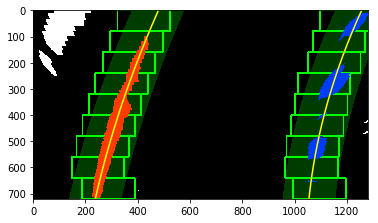

In [166]:
compute_and_visualize_sliding_windows(sample_combined_binary_psp_tr)

# Pipeline Definition

In [167]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [168]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [187]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [381]:
class AdvancedLaneDetectorWithMemory:
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        final_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        #plt.imshow(final_img)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        #print("pts shape = {0}".format(pts[0]))
        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (200, 0, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (200, 0, 0))
        #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        #plt.imshow(result)
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified are colored
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
        #if False:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [382]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [383]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=38447.59511266854


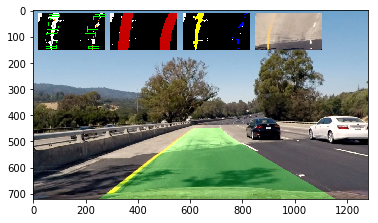

In [384]:
plt.imshow(proc_img)

In [ ]:
#(720, 1280, 3)

# Normal video

In [174]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [175]:
project_video_path = "project_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'

In [385]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 20, 30, targetname=project_video_sample_path)


[MoviePy] Running:
>>> /Users/eddieforson/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i project_video.mp4 -ss 20.00 -t 10.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [386]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=33746.297764791816
[MoviePy] >>>> Building video output_videos/lanes_project_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_project_video_sample.mp4



  0%|          | 1/251 [00:01<04:40,  1.12s/it]

[Previous lane] Found pct=0.9947699050401753



  1%|          | 2/251 [00:02<04:45,  1.15s/it]

[Previous lane] Found pct=0.9947406866325785



  1%|          | 3/251 [00:03<04:44,  1.15s/it]

[Previous lane] Found pct=0.994682249817385



  2%|▏         | 4/251 [00:04<04:41,  1.14s/it]

[Previous lane] Found pct=0.9946676406135866



  2%|▏         | 5/251 [00:05<04:41,  1.14s/it]

[Previous lane] Found pct=0.9946530314097881



  2%|▏         | 6/251 [00:06<04:38,  1.14s/it]

[Previous lane] Found pct=0.9946530314097881



  3%|▎         | 7/251 [00:08<04:38,  1.14s/it]

[Previous lane] Found pct=0.9946530314097881



  3%|▎         | 8/251 [00:09<04:41,  1.16s/it]

[Previous lane] Found pct=0.9946530314097881



  4%|▎         | 9/251 [00:10<04:51,  1.20s/it]

[Previous lane] Found pct=0.9946530314097881



  4%|▍         | 10/251 [00:11<04:55,  1.23s/it]

[Previous lane] Found pct=0.9946530314097881



  4%|▍         | 11/251 [00:12<04:47,  1.20s/it]

[Previous lane] Found pct=0.9946530314097881



  5%|▍         | 12/251 [00:14<04:40,  1.17s/it]

[Previous lane] Found pct=0.9937085802703413



  5%|▌         | 13/251 [00:15<04:35,  1.16s/it]

[Previous lane] Found pct=0.9783143401883305



  6%|▌         | 14/251 [00:16<04:32,  1.15s/it]

[Previous lane] Found pct=0.9893588189144854



  6%|▌         | 15/251 [00:17<04:29,  1.14s/it]

[Previous lane] Found pct=0.991199778170196



  6%|▋         | 16/251 [00:18<04:32,  1.16s/it]

[Previous lane] Found pct=0.990042989466842



  7%|▋         | 17/251 [00:20<04:53,  1.26s/it]

[Previous lane] Found pct=0.9919559695173582



  7%|▋         | 18/251 [00:21<05:08,  1.32s/it]

[Previous lane] Found pct=0.98984375



  8%|▊         | 19/251 [00:22<05:02,  1.31s/it]

[Previous lane] Found pct=0.9775974598694656



  8%|▊         | 20/251 [00:24<04:50,  1.26s/it]

[Previous lane] Found pct=0.9791503935588536



  8%|▊         | 21/251 [00:25<04:41,  1.22s/it]

[Previous lane] Found pct=0.970175325095426



  9%|▉         | 22/251 [00:26<04:34,  1.20s/it]

[Previous lane] Found pct=0.9402265493353305



  9%|▉         | 23/251 [00:27<04:28,  1.18s/it]

[Previous lane] Found pct=0.8760915173508732



 10%|▉         | 24/251 [00:28<04:25,  1.17s/it]

[Previous lane] Found pct=0.8182925327385432
Non zeros found below thresholds, begining sliding window - pct=0.8182925327385432
[Sliding windows] Found pct=34183.54691498241



 10%|▉         | 25/251 [00:29<04:28,  1.19s/it]

[Previous lane] Found pct=0.7440605323032965
Non zeros found below thresholds, begining sliding window - pct=0.7440605323032965
[Sliding windows] Found pct=33900.30024075348



 10%|█         | 26/251 [00:30<04:20,  1.16s/it]

[Previous lane] Found pct=0.8481797290759555
Non zeros found below thresholds, begining sliding window - pct=0.8481797290759555
[Sliding windows] Found pct=31060.813331519108



 11%|█         | 27/251 [00:31<04:15,  1.14s/it]

[Previous lane] Found pct=0.8158557544150764
Non zeros found below thresholds, begining sliding window - pct=0.8158557544150764
[Sliding windows] Found pct=31804.453804669905



 11%|█         | 28/251 [00:33<04:14,  1.14s/it]

[Previous lane] Found pct=0.8049247829100249
Non zeros found below thresholds, begining sliding window - pct=0.8049247829100249
[Sliding windows] Found pct=34020.71773546958



 12%|█▏        | 29/251 [00:34<04:10,  1.13s/it]

[Previous lane] Found pct=0.7630387638926538
Non zeros found below thresholds, begining sliding window - pct=0.7630387638926538
[Sliding windows] Found pct=33154.71452968284



 12%|█▏        | 30/251 [00:35<04:09,  1.13s/it]

[Previous lane] Found pct=0.6942457112085545
Non zeros found below thresholds, begining sliding window - pct=0.6942457112085545
[Sliding windows] Found pct=32524.247506218428



 12%|█▏        | 31/251 [00:36<04:12,  1.15s/it]

[Previous lane] Found pct=0.7252372629176478
Non zeros found below thresholds, begining sliding window - pct=0.7252372629176478
[Sliding windows] Found pct=29195.283559882704



 13%|█▎        | 32/251 [00:37<04:07,  1.13s/it]

[Previous lane] Found pct=0.7128560820845147
Non zeros found below thresholds, begining sliding window - pct=0.7128560820845147
[Sliding windows] Found pct=25101.191035506952



 13%|█▎        | 33/251 [00:38<04:07,  1.14s/it]

[Previous lane] Found pct=0.6932927418575433
Non zeros found below thresholds, begining sliding window - pct=0.6932927418575433
[Sliding windows] Found pct=25378.035855803613



 14%|█▎        | 34/251 [00:39<04:04,  1.13s/it]

[Previous lane] Found pct=0.6915387691077415
Non zeros found below thresholds, begining sliding window - pct=0.6915387691077415
[Sliding windows] Found pct=25783.456601974594



 14%|█▍        | 35/251 [00:41<04:03,  1.13s/it]

[Previous lane] Found pct=0.7257838908963749
Non zeros found below thresholds, begining sliding window - pct=0.7257838908963749
[Sliding windows] Found pct=26659.259747639586



 14%|█▍        | 36/251 [00:42<04:02,  1.13s/it]

[Previous lane] Found pct=0.7385030653706443
Non zeros found below thresholds, begining sliding window - pct=0.7385030653706443
[Sliding windows] Found pct=27389.74843859926



 15%|█▍        | 37/251 [00:43<04:02,  1.13s/it]

[Previous lane] Found pct=0.7320523587501085
Non zeros found below thresholds, begining sliding window - pct=0.7320523587501085
[Sliding windows] Found pct=26818.654571254814



 15%|█▌        | 38/251 [00:44<04:01,  1.13s/it]

[Previous lane] Found pct=0.7305894441308847
Non zeros found below thresholds, begining sliding window - pct=0.7305894441308847
[Sliding windows] Found pct=26897.959782341277



 16%|█▌        | 39/251 [00:45<03:59,  1.13s/it]

[Previous lane] Found pct=0.7436888122652546
Non zeros found below thresholds, begining sliding window - pct=0.7436888122652546
[Sliding windows] Found pct=25165.778231020256



 16%|█▌        | 40/251 [00:46<03:57,  1.13s/it]

[Previous lane] Found pct=0.7252536538229255
Non zeros found below thresholds, begining sliding window - pct=0.7252536538229255
[Sliding windows] Found pct=25077.739144220315



 16%|█▋        | 41/251 [00:47<03:54,  1.12s/it]

[Previous lane] Found pct=0.7296232526920944
Non zeros found below thresholds, begining sliding window - pct=0.7296232526920944
[Sliding windows] Found pct=25515.72515831558



 17%|█▋        | 42/251 [00:48<03:57,  1.14s/it]

[Previous lane] Found pct=0.7798489374012855
Non zeros found below thresholds, begining sliding window - pct=0.7798489374012855
[Sliding windows] Found pct=24926.914069463775



 17%|█▋        | 43/251 [00:50<03:59,  1.15s/it]

[Previous lane] Found pct=0.7970963528584346
Non zeros found below thresholds, begining sliding window - pct=0.7970963528584346
[Sliding windows] Found pct=23388.177634883956



 18%|█▊        | 44/251 [00:51<03:59,  1.16s/it]

[Previous lane] Found pct=0.7970403587443946
Non zeros found below thresholds, begining sliding window - pct=0.7970403587443946
[Sliding windows] Found pct=21941.03397309417



 18%|█▊        | 45/251 [00:52<03:55,  1.14s/it]

[Previous lane] Found pct=0.8049145453234298
Non zeros found below thresholds, begining sliding window - pct=0.8049145453234298
[Sliding windows] Found pct=21102.00746376289



 18%|█▊        | 46/251 [00:53<03:52,  1.13s/it]

[Previous lane] Found pct=0.7878506176591522
Non zeros found below thresholds, begining sliding window - pct=0.7878506176591522
[Sliding windows] Found pct=20598.679049645136



 19%|█▊        | 47/251 [00:54<03:50,  1.13s/it]

[Previous lane] Found pct=0.7797446569376394
Non zeros found below thresholds, begining sliding window - pct=0.7797446569376394
[Sliding windows] Found pct=20655.77993783257



 19%|█▉        | 48/251 [00:55<03:48,  1.13s/it]

[Previous lane] Found pct=0.8018405018243255
Non zeros found below thresholds, begining sliding window - pct=0.8018405018243255
[Sliding windows] Found pct=20492.16656182037



 20%|█▉        | 49/251 [00:56<03:47,  1.13s/it]

[Previous lane] Found pct=0.7991780244485036
Non zeros found below thresholds, begining sliding window - pct=0.7991780244485036
[Sliding windows] Found pct=20987.49996487284



 20%|█▉        | 50/251 [00:58<03:46,  1.13s/it]

[Previous lane] Found pct=0.7811158798283262
Non zeros found below thresholds, begining sliding window - pct=0.7811158798283262
[Sliding windows] Found pct=22321.218282611524



 20%|██        | 51/251 [00:59<03:47,  1.14s/it]

[Previous lane] Found pct=0.8032293554232461
Non zeros found below thresholds, begining sliding window - pct=0.8032293554232461
[Sliding windows] Found pct=22377.499142505825



 21%|██        | 52/251 [01:00<03:46,  1.14s/it]

[Previous lane] Found pct=0.7846560164905952
Non zeros found below thresholds, begining sliding window - pct=0.7846560164905952
[Sliding windows] Found pct=21715.252302885856



 21%|██        | 53/251 [01:01<03:42,  1.12s/it]

[Previous lane] Found pct=0.7889424499242991
Non zeros found below thresholds, begining sliding window - pct=0.7889424499242991
[Sliding windows] Found pct=19984.50169674399



 22%|██▏       | 54/251 [01:02<03:41,  1.12s/it]

[Previous lane] Found pct=0.781574354735005
Non zeros found below thresholds, begining sliding window - pct=0.781574354735005
[Sliding windows] Found pct=18511.193092679343



 22%|██▏       | 55/251 [01:03<03:41,  1.13s/it]

[Previous lane] Found pct=0.7773770018756312
Non zeros found below thresholds, begining sliding window - pct=0.7773770018756312
[Sliding windows] Found pct=16477.279345384093



 22%|██▏       | 56/251 [01:04<03:40,  1.13s/it]

[Previous lane] Found pct=0.7773518671696895
Non zeros found below thresholds, begining sliding window - pct=0.7773518671696895
[Sliding windows] Found pct=16957.841124135008



 23%|██▎       | 57/251 [01:05<03:41,  1.14s/it]

[Previous lane] Found pct=0.7234922874520945
Non zeros found below thresholds, begining sliding window - pct=0.7234922874520945
[Sliding windows] Found pct=16599.53861994013



 23%|██▎       | 58/251 [01:07<03:38,  1.13s/it]

[Previous lane] Found pct=0.7098986340896741
Non zeros found below thresholds, begining sliding window - pct=0.7098986340896741
[Sliding windows] Found pct=17374.718161548408



 24%|██▎       | 59/251 [01:08<03:38,  1.14s/it]

[Previous lane] Found pct=0.7467458509599739
Non zeros found below thresholds, begining sliding window - pct=0.7467458509599739
[Sliding windows] Found pct=17025.18208997722



 24%|██▍       | 60/251 [01:09<03:37,  1.14s/it]

[Previous lane] Found pct=0.6037421046359195
Non zeros found below thresholds, begining sliding window - pct=0.6037421046359195
[Sliding windows] Found pct=17711.920549795417



 24%|██▍       | 61/251 [01:10<03:37,  1.14s/it]

[Previous lane] Found pct=0.7803363215562196
Non zeros found below thresholds, begining sliding window - pct=0.7803363215562196
[Sliding windows] Found pct=18406.57035995391



 25%|██▍       | 62/251 [01:11<03:32,  1.13s/it]

[Previous lane] Found pct=0.8108135731807032
Non zeros found below thresholds, begining sliding window - pct=0.8108135731807032
[Sliding windows] Found pct=18536.904783319707



 25%|██▌       | 63/251 [01:12<03:32,  1.13s/it]

[Previous lane] Found pct=0.6215896376624495
Non zeros found below thresholds, begining sliding window - pct=0.6215896376624495
[Sliding windows] Found pct=18202.154230140288



 25%|██▌       | 64/251 [01:13<03:29,  1.12s/it]

[Previous lane] Found pct=0.7664530654658815
Non zeros found below thresholds, begining sliding window - pct=0.7664530654658815
[Sliding windows] Found pct=13818.22503175153



 26%|██▌       | 65/251 [01:15<03:29,  1.13s/it]

[Previous lane] Found pct=0.7595450080795919
Non zeros found below thresholds, begining sliding window - pct=0.7595450080795919
[Sliding windows] Found pct=12916.784702639334



 26%|██▋       | 66/251 [01:16<03:29,  1.13s/it]

[Previous lane] Found pct=0.7858566653377902
Non zeros found below thresholds, begining sliding window - pct=0.7858566653377902
[Sliding windows] Found pct=13669.291207948725



 27%|██▋       | 67/251 [01:17<03:28,  1.13s/it]

[Previous lane] Found pct=0.8831653471907369



 27%|██▋       | 68/251 [01:18<03:27,  1.13s/it]

[Previous lane] Found pct=0.9038323525190183



 27%|██▋       | 69/251 [01:19<03:27,  1.14s/it]

[Previous lane] Found pct=0.8912539184952978



 28%|██▊       | 70/251 [01:20<03:25,  1.13s/it]

[Previous lane] Found pct=0.8846950725159896



 28%|██▊       | 71/251 [01:21<03:24,  1.14s/it]

[Previous lane] Found pct=0.847223460201444
Non zeros found below thresholds, begining sliding window - pct=0.847223460201444
[Sliding windows] Found pct=14747.30403779303



 29%|██▊       | 72/251 [01:22<03:22,  1.13s/it]

[Previous lane] Found pct=0.880579182431087



 29%|██▉       | 73/251 [01:24<03:24,  1.15s/it]

[Previous lane] Found pct=0.8881285759466375



 29%|██▉       | 74/251 [01:25<03:22,  1.14s/it]

[Previous lane] Found pct=0.8845817454863497



 30%|██▉       | 75/251 [01:26<03:36,  1.23s/it]

[Previous lane] Found pct=0.8692333785617368



 30%|███       | 76/251 [01:27<03:35,  1.23s/it]

[Previous lane] Found pct=0.8664903289799967



 31%|███       | 77/251 [01:29<03:31,  1.22s/it]

[Previous lane] Found pct=0.8927960526315789



 31%|███       | 78/251 [01:30<03:25,  1.19s/it]

[Previous lane] Found pct=0.8916021441334128



 31%|███▏      | 79/251 [01:31<03:21,  1.17s/it]

[Previous lane] Found pct=0.8930854556135319



 32%|███▏      | 80/251 [01:32<03:17,  1.16s/it]

[Previous lane] Found pct=0.8834594661932792



 32%|███▏      | 81/251 [01:33<03:16,  1.16s/it]

[Previous lane] Found pct=0.9037403227310885



 33%|███▎      | 82/251 [01:34<03:16,  1.16s/it]

[Previous lane] Found pct=0.889308426073132



 33%|███▎      | 83/251 [01:36<03:16,  1.17s/it]

[Previous lane] Found pct=0.8934578817897746



 33%|███▎      | 84/251 [01:37<03:14,  1.17s/it]

[Previous lane] Found pct=0.9078019367805591



 34%|███▍      | 85/251 [01:38<03:11,  1.15s/it]

[Previous lane] Found pct=0.9023169089465143



 34%|███▍      | 86/251 [01:39<03:09,  1.15s/it]

[Previous lane] Found pct=0.8949238943136129



 35%|███▍      | 87/251 [01:40<03:07,  1.14s/it]

[Previous lane] Found pct=0.9054540272879484



 35%|███▌      | 88/251 [01:41<03:06,  1.14s/it]

[Previous lane] Found pct=0.887808554739024



 35%|███▌      | 89/251 [01:42<03:04,  1.14s/it]

[Previous lane] Found pct=0.8919122919575802



 36%|███▌      | 90/251 [01:44<03:04,  1.15s/it]

[Previous lane] Found pct=0.9075411300528549



 36%|███▋      | 91/251 [01:45<03:03,  1.14s/it]

[Previous lane] Found pct=0.903995848469123



 37%|███▋      | 92/251 [01:46<03:01,  1.14s/it]

[Previous lane] Found pct=0.8734019685484783



 37%|███▋      | 93/251 [01:47<02:59,  1.13s/it]

[Previous lane] Found pct=0.8302645886190648
Non zeros found below thresholds, begining sliding window - pct=0.8302645886190648
[Sliding windows] Found pct=11598.771148967016



 37%|███▋      | 94/251 [01:48<02:58,  1.14s/it]

[Previous lane] Found pct=0.8438333748354736
Non zeros found below thresholds, begining sliding window - pct=0.8438333748354736
[Sliding windows] Found pct=11711.629362171392



 38%|███▊      | 95/251 [01:49<03:01,  1.16s/it]

[Previous lane] Found pct=0.888129508819164



 38%|███▊      | 96/251 [01:50<03:00,  1.16s/it]

[Previous lane] Found pct=0.8679635761589404



 39%|███▊      | 97/251 [01:52<02:56,  1.15s/it]

[Previous lane] Found pct=0.8995254152616461



 39%|███▉      | 98/251 [01:53<02:54,  1.14s/it]

[Previous lane] Found pct=0.8876024945143781



 39%|███▉      | 99/251 [01:54<02:52,  1.14s/it]

[Previous lane] Found pct=0.8733981498466941



 40%|███▉      | 100/251 [01:55<02:52,  1.14s/it]

[Previous lane] Found pct=0.90912412862604



 40%|████      | 101/251 [01:56<02:50,  1.14s/it]

[Previous lane] Found pct=0.8498614958448754
Non zeros found below thresholds, begining sliding window - pct=0.8498614958448754
[Sliding windows] Found pct=16760.83208259884



 41%|████      | 102/251 [01:57<02:50,  1.14s/it]

[Previous lane] Found pct=0.8819970525118287



 41%|████      | 103/251 [01:58<02:49,  1.15s/it]

[Previous lane] Found pct=0.8962731778960896



 41%|████▏     | 104/251 [02:00<02:47,  1.14s/it]

[Previous lane] Found pct=0.8985255411034165



 42%|████▏     | 105/251 [02:01<02:46,  1.14s/it]

[Previous lane] Found pct=0.8510860757508429



 42%|████▏     | 106/251 [02:02<02:44,  1.13s/it]

[Previous lane] Found pct=0.8642990359610182



 43%|████▎     | 107/251 [02:03<02:46,  1.15s/it]

[Previous lane] Found pct=0.9554247710538123



 43%|████▎     | 108/251 [02:04<02:44,  1.15s/it]

[Previous lane] Found pct=0.922759150734941



 43%|████▎     | 109/251 [02:05<02:43,  1.15s/it]

[Previous lane] Found pct=0.9249627837737253



 44%|████▍     | 110/251 [02:06<02:41,  1.15s/it]

[Previous lane] Found pct=0.9218614024641597



 44%|████▍     | 111/251 [02:08<02:39,  1.14s/it]

[Previous lane] Found pct=0.9200298446720477



 45%|████▍     | 112/251 [02:09<02:38,  1.14s/it]

[Previous lane] Found pct=0.9123129059587687



 45%|████▌     | 113/251 [02:10<02:35,  1.12s/it]

[Previous lane] Found pct=0.9149986946305805



 45%|████▌     | 114/251 [02:11<02:35,  1.13s/it]

[Previous lane] Found pct=0.9274258132940846



 46%|████▌     | 115/251 [02:12<02:35,  1.14s/it]

[Previous lane] Found pct=0.9233578165428595



 46%|████▌     | 116/251 [02:13<02:34,  1.15s/it]

[Previous lane] Found pct=0.9279782330605698



 47%|████▋     | 117/251 [02:14<02:32,  1.14s/it]

[Previous lane] Found pct=0.9156104918803503



 47%|████▋     | 118/251 [02:16<02:33,  1.15s/it]

[Previous lane] Found pct=0.9359169972535856



 47%|████▋     | 119/251 [02:17<02:41,  1.22s/it]

[Previous lane] Found pct=0.9014577871001573



 48%|████▊     | 120/251 [02:18<02:40,  1.23s/it]

[Previous lane] Found pct=0.9455905736535247



 48%|████▊     | 121/251 [02:19<02:38,  1.22s/it]

[Previous lane] Found pct=0.9499427975031612



 49%|████▊     | 122/251 [02:21<02:39,  1.24s/it]

[Previous lane] Found pct=0.9667439911109378



 49%|████▉     | 123/251 [02:22<02:39,  1.24s/it]

[Previous lane] Found pct=0.9664814447310974



 49%|████▉     | 124/251 [02:23<02:40,  1.26s/it]

[Previous lane] Found pct=0.967327076816128



 50%|████▉     | 125/251 [02:25<02:42,  1.29s/it]

[Previous lane] Found pct=0.7496844762305427
Non zeros found below thresholds, begining sliding window - pct=0.7496844762305427
[Sliding windows] Found pct=24181.327207710252



 50%|█████     | 126/251 [02:26<02:47,  1.34s/it]

[Previous lane] Found pct=0.8671242228003173



 51%|█████     | 127/251 [02:27<02:46,  1.34s/it]

[Previous lane] Found pct=0.8960267701189579



 51%|█████     | 128/251 [02:28<02:37,  1.28s/it]

[Previous lane] Found pct=0.8531003217315004



 51%|█████▏    | 129/251 [02:30<02:32,  1.25s/it]

[Previous lane] Found pct=0.8287864849042402
Non zeros found below thresholds, begining sliding window - pct=0.8287864849042402
[Sliding windows] Found pct=26460.298335702937



 52%|█████▏    | 130/251 [02:31<02:28,  1.23s/it]

[Previous lane] Found pct=0.7944593386952636
Non zeros found below thresholds, begining sliding window - pct=0.7944593386952636
[Sliding windows] Found pct=26566.41295799821



 52%|█████▏    | 131/251 [02:32<02:23,  1.20s/it]

[Previous lane] Found pct=0.8929737010239851



 53%|█████▎    | 132/251 [02:33<02:22,  1.20s/it]

[Previous lane] Found pct=0.9200082714411263



 53%|█████▎    | 133/251 [02:34<02:20,  1.19s/it]

[Previous lane] Found pct=0.9869189521500051



 53%|█████▎    | 134/251 [02:36<02:18,  1.18s/it]

[Previous lane] Found pct=0.9644175402332792



 54%|█████▍    | 135/251 [02:37<02:13,  1.15s/it]

[Previous lane] Found pct=0.8695695397156775



 54%|█████▍    | 136/251 [02:38<02:12,  1.15s/it]

[Previous lane] Found pct=0.7710011136037185
Non zeros found below thresholds, begining sliding window - pct=0.7710011136037185
[Sliding windows] Found pct=28403.09226771679



 55%|█████▍    | 137/251 [02:39<02:12,  1.16s/it]

[Previous lane] Found pct=0.7999719701482079
Non zeros found below thresholds, begining sliding window - pct=0.7999719701482079
[Sliding windows] Found pct=26065.3467993413



 55%|█████▍    | 138/251 [02:40<02:09,  1.15s/it]

[Previous lane] Found pct=0.8883458457197562



 55%|█████▌    | 139/251 [02:41<02:07,  1.14s/it]

[Previous lane] Found pct=0.9243108023595829



 56%|█████▌    | 140/251 [02:42<02:07,  1.15s/it]

[Previous lane] Found pct=0.8696619068320904



 56%|█████▌    | 141/251 [02:43<02:06,  1.15s/it]

[Previous lane] Found pct=0.8028899236714512
Non zeros found below thresholds, begining sliding window - pct=0.8028899236714512
[Sliding windows] Found pct=29552.236842526363



 57%|█████▋    | 142/251 [02:45<02:06,  1.16s/it]

[Previous lane] Found pct=0.9875817097923892



 57%|█████▋    | 143/251 [02:46<02:03,  1.15s/it]

[Previous lane] Found pct=0.9832809059452658



 57%|█████▋    | 144/251 [02:47<02:03,  1.16s/it]

[Previous lane] Found pct=0.9690177875876396



 58%|█████▊    | 145/251 [02:48<02:01,  1.15s/it]

[Previous lane] Found pct=0.9863595563249343



 58%|█████▊    | 146/251 [02:49<02:03,  1.18s/it]

[Previous lane] Found pct=0.9731584692223729



 59%|█████▊    | 147/251 [02:50<02:00,  1.16s/it]

[Previous lane] Found pct=0.9858475077165562



 59%|█████▉    | 148/251 [02:52<01:58,  1.15s/it]

[Previous lane] Found pct=0.985029602026166



 59%|█████▉    | 149/251 [02:53<01:57,  1.15s/it]

[Previous lane] Found pct=0.9544888168961435



 60%|█████▉    | 150/251 [02:54<02:01,  1.21s/it]

[Previous lane] Found pct=0.9543820635452523



 60%|██████    | 151/251 [02:56<02:10,  1.31s/it]

[Previous lane] Found pct=0.9333333333333333



 61%|██████    | 152/251 [02:57<02:11,  1.33s/it]

[Previous lane] Found pct=0.9098765612020345



 61%|██████    | 153/251 [02:59<02:15,  1.39s/it]

[Previous lane] Found pct=0.8946655875211537



 61%|██████▏   | 154/251 [03:00<02:08,  1.33s/it]

[Previous lane] Found pct=0.8691916993179509



 62%|██████▏   | 155/251 [03:01<02:02,  1.28s/it]

[Previous lane] Found pct=0.8312523750067857
Non zeros found below thresholds, begining sliding window - pct=0.8312523750067857
[Sliding windows] Found pct=33286.515145757556



 62%|██████▏   | 156/251 [03:02<01:58,  1.24s/it]

[Previous lane] Found pct=0.8398616717873824
Non zeros found below thresholds, begining sliding window - pct=0.8398616717873824
[Sliding windows] Found pct=33028.25911739987



 63%|██████▎   | 157/251 [03:03<01:54,  1.22s/it]

[Previous lane] Found pct=0.8317892064178056
Non zeros found below thresholds, begining sliding window - pct=0.8317892064178056
[Sliding windows] Found pct=33191.34598346929



 63%|██████▎   | 158/251 [03:04<01:52,  1.21s/it]

[Previous lane] Found pct=0.7968741636782102
Non zeros found below thresholds, begining sliding window - pct=0.7968741636782102
[Sliding windows] Found pct=33427.454477332336



 63%|██████▎   | 159/251 [03:06<01:51,  1.21s/it]

[Previous lane] Found pct=0.8445155902004454
Non zeros found below thresholds, begining sliding window - pct=0.8445155902004454
[Sliding windows] Found pct=32545.05768374165



 64%|██████▎   | 160/251 [03:07<01:59,  1.31s/it]

[Previous lane] Found pct=0.836181640625
Non zeros found below thresholds, begining sliding window - pct=0.836181640625
[Sliding windows] Found pct=33592.04808213976



 64%|██████▍   | 161/251 [03:09<02:03,  1.37s/it]

[Previous lane] Found pct=0.8912934432103189



 65%|██████▍   | 162/251 [03:10<01:59,  1.35s/it]

[Previous lane] Found pct=0.9307998672419515



 65%|██████▍   | 163/251 [03:11<01:58,  1.35s/it]

[Previous lane] Found pct=0.9438410757202397



 65%|██████▌   | 164/251 [03:12<01:53,  1.30s/it]

[Previous lane] Found pct=0.9555111733161396



 66%|██████▌   | 165/251 [03:14<01:48,  1.26s/it]

[Previous lane] Found pct=0.9269204727317494



 66%|██████▌   | 166/251 [03:15<01:54,  1.35s/it]

[Previous lane] Found pct=0.9055304400241109



 67%|██████▋   | 167/251 [03:17<01:54,  1.37s/it]

[Previous lane] Found pct=0.8818078192772868



 67%|██████▋   | 168/251 [03:18<01:55,  1.39s/it]

[Previous lane] Found pct=0.9205087440381559



 67%|██████▋   | 169/251 [03:19<01:49,  1.34s/it]

[Previous lane] Found pct=0.935858953368504



 68%|██████▊   | 170/251 [03:21<01:50,  1.37s/it]

[Previous lane] Found pct=0.9543105544747081



 68%|██████▊   | 171/251 [03:22<01:47,  1.34s/it]

[Previous lane] Found pct=0.9527211503458318



 69%|██████▊   | 172/251 [03:23<01:46,  1.35s/it]

[Previous lane] Found pct=0.9333895188476862



 69%|██████▉   | 173/251 [03:25<01:48,  1.38s/it]

[Previous lane] Found pct=0.9483060258926262



 69%|██████▉   | 174/251 [03:26<01:48,  1.42s/it]

[Previous lane] Found pct=0.9682242099744205



 70%|██████▉   | 175/251 [03:28<01:44,  1.38s/it]

[Previous lane] Found pct=0.9535542425534507



 70%|███████   | 176/251 [03:29<01:39,  1.33s/it]

[Previous lane] Found pct=0.9291573907474612



 71%|███████   | 177/251 [03:30<01:33,  1.27s/it]

[Previous lane] Found pct=0.9434645521805638



 71%|███████   | 178/251 [03:31<01:30,  1.24s/it]

[Previous lane] Found pct=0.9452706722189174



 71%|███████▏  | 179/251 [03:32<01:27,  1.22s/it]

[Previous lane] Found pct=0.8940395388126501



 72%|███████▏  | 180/251 [03:34<01:28,  1.24s/it]

[Previous lane] Found pct=0.9118449234941522



 72%|███████▏  | 181/251 [03:35<01:26,  1.24s/it]

[Previous lane] Found pct=0.9071805175773874



 73%|███████▎  | 182/251 [03:36<01:26,  1.25s/it]

[Previous lane] Found pct=0.917691041400637



 73%|███████▎  | 183/251 [03:37<01:23,  1.23s/it]

[Previous lane] Found pct=0.9061343808523272



 73%|███████▎  | 184/251 [03:38<01:21,  1.21s/it]

[Previous lane] Found pct=0.9016016932614798



 74%|███████▎  | 185/251 [03:40<01:17,  1.18s/it]

[Previous lane] Found pct=0.9392049487881554



 74%|███████▍  | 186/251 [03:41<01:15,  1.16s/it]

[Previous lane] Found pct=0.8771665628936737



 75%|███████▍  | 187/251 [03:42<01:12,  1.14s/it]

[Previous lane] Found pct=0.9659424965942497



 75%|███████▍  | 188/251 [03:43<01:11,  1.14s/it]

[Previous lane] Found pct=0.9147872324355353



 75%|███████▌  | 189/251 [03:44<01:09,  1.13s/it]

[Previous lane] Found pct=0.9855471678376541



 76%|███████▌  | 190/251 [03:45<01:09,  1.14s/it]

[Previous lane] Found pct=0.9946345091372716



 76%|███████▌  | 191/251 [03:46<01:08,  1.14s/it]

[Previous lane] Found pct=0.9800357031723415



 76%|███████▋  | 192/251 [03:47<01:07,  1.14s/it]

[Previous lane] Found pct=0.9972200684581781



 77%|███████▋  | 193/251 [03:49<01:06,  1.15s/it]

[Previous lane] Found pct=0.9622931710002267



 77%|███████▋  | 194/251 [03:50<01:04,  1.14s/it]

[Previous lane] Found pct=0.98900540085572



 78%|███████▊  | 195/251 [03:51<01:03,  1.13s/it]

[Previous lane] Found pct=0.9901600474214582



 78%|███████▊  | 196/251 [03:52<01:02,  1.13s/it]

[Previous lane] Found pct=0.9647595923671431



 78%|███████▊  | 197/251 [03:53<01:01,  1.13s/it]

[Previous lane] Found pct=0.980175896464195



 79%|███████▉  | 198/251 [03:54<00:59,  1.13s/it]

[Previous lane] Found pct=0.8990976719626023



 79%|███████▉  | 199/251 [03:55<00:58,  1.12s/it]

[Previous lane] Found pct=0.9091757737683283



 80%|███████▉  | 200/251 [03:56<00:56,  1.12s/it]

[Previous lane] Found pct=0.8823229986117538



 80%|████████  | 201/251 [03:58<00:55,  1.12s/it]

[Previous lane] Found pct=0.92481241473397



 80%|████████  | 202/251 [03:59<00:55,  1.12s/it]

[Previous lane] Found pct=0.8876620259241479



 81%|████████  | 203/251 [04:00<00:53,  1.12s/it]

[Previous lane] Found pct=0.9200216290615937



 81%|████████▏ | 204/251 [04:01<00:52,  1.12s/it]

[Previous lane] Found pct=0.9357255388328362



 82%|████████▏ | 205/251 [04:02<00:51,  1.12s/it]

[Previous lane] Found pct=0.8987130749096348



 82%|████████▏ | 206/251 [04:03<00:50,  1.13s/it]

[Previous lane] Found pct=0.938302347101876



 82%|████████▏ | 207/251 [04:04<00:49,  1.12s/it]

[Previous lane] Found pct=0.9390206193955767



 83%|████████▎ | 208/251 [04:05<00:48,  1.14s/it]

[Previous lane] Found pct=0.9590139795936043



 83%|████████▎ | 209/251 [04:07<00:48,  1.14s/it]

[Previous lane] Found pct=0.9385956108657835



 84%|████████▎ | 210/251 [04:08<00:46,  1.13s/it]

[Previous lane] Found pct=0.9205593622348135



 84%|████████▍ | 211/251 [04:09<00:45,  1.13s/it]

[Previous lane] Found pct=0.9026374553006762



 84%|████████▍ | 212/251 [04:10<00:44,  1.13s/it]

[Previous lane] Found pct=0.9366166738718367



 85%|████████▍ | 213/251 [04:11<00:42,  1.12s/it]

[Previous lane] Found pct=0.9597818109027824



 85%|████████▌ | 214/251 [04:12<00:41,  1.12s/it]

[Previous lane] Found pct=0.970583154840047



 86%|████████▌ | 215/251 [04:13<00:40,  1.11s/it]

[Previous lane] Found pct=0.9829075777649232



 86%|████████▌ | 216/251 [04:14<00:39,  1.11s/it]

[Previous lane] Found pct=0.9740178009529803



 86%|████████▋ | 217/251 [04:16<00:37,  1.12s/it]

[Previous lane] Found pct=0.9900718288142605



 87%|████████▋ | 218/251 [04:17<00:37,  1.14s/it]

[Previous lane] Found pct=0.9770451339915374



 87%|████████▋ | 219/251 [04:18<00:35,  1.12s/it]

[Previous lane] Found pct=0.9756132067129998



 88%|████████▊ | 220/251 [04:19<00:35,  1.13s/it]

[Previous lane] Found pct=0.988164964840443



 88%|████████▊ | 221/251 [04:20<00:33,  1.13s/it]

[Previous lane] Found pct=0.9613266911379129



 88%|████████▊ | 222/251 [04:21<00:32,  1.13s/it]

[Previous lane] Found pct=0.9652850089012798



 89%|████████▉ | 223/251 [04:22<00:31,  1.11s/it]

[Previous lane] Found pct=0.9443515377387038



 89%|████████▉ | 224/251 [04:23<00:30,  1.12s/it]

[Previous lane] Found pct=0.9493038438478449



 90%|████████▉ | 225/251 [04:25<00:29,  1.12s/it]

[Previous lane] Found pct=0.9498099855851133



 90%|█████████ | 226/251 [04:26<00:27,  1.12s/it]

[Previous lane] Found pct=0.9768047501649363



 90%|█████████ | 227/251 [04:27<00:26,  1.11s/it]

[Previous lane] Found pct=0.959174639926453



 91%|█████████ | 228/251 [04:28<00:25,  1.13s/it]

[Previous lane] Found pct=0.9711345293060304



 91%|█████████ | 229/251 [04:29<00:24,  1.13s/it]

[Previous lane] Found pct=0.9477292761761729



 92%|█████████▏| 230/251 [04:30<00:23,  1.13s/it]

[Previous lane] Found pct=0.9734432549654056



 92%|█████████▏| 231/251 [04:31<00:22,  1.12s/it]

[Previous lane] Found pct=0.9435531487760852



 92%|█████████▏| 232/251 [04:32<00:21,  1.11s/it]

[Previous lane] Found pct=0.948744311478173



 93%|█████████▎| 233/251 [04:34<00:20,  1.12s/it]

[Previous lane] Found pct=0.9234563265863399



 93%|█████████▎| 234/251 [04:35<00:19,  1.12s/it]

[Previous lane] Found pct=0.9051703838261513



 94%|█████████▎| 235/251 [04:36<00:18,  1.13s/it]

[Previous lane] Found pct=0.9343972535223236



 94%|█████████▍| 236/251 [04:37<00:16,  1.12s/it]

[Previous lane] Found pct=0.8857782930191753



 94%|█████████▍| 237/251 [04:38<00:15,  1.12s/it]

[Previous lane] Found pct=0.8923550087873462



 95%|█████████▍| 238/251 [04:39<00:14,  1.13s/it]

[Previous lane] Found pct=0.8855905006418485



 95%|█████████▌| 239/251 [04:40<00:13,  1.13s/it]

[Previous lane] Found pct=0.8823987926430834



 96%|█████████▌| 240/251 [04:41<00:12,  1.13s/it]

[Previous lane] Found pct=0.8565251633028089



 96%|█████████▌| 241/251 [04:43<00:11,  1.12s/it]

[Previous lane] Found pct=0.8636484312776225



 96%|█████████▋| 242/251 [04:44<00:10,  1.12s/it]

[Previous lane] Found pct=0.8754980554012223



 97%|█████████▋| 243/251 [04:45<00:09,  1.13s/it]

[Previous lane] Found pct=0.8635776876699014



 97%|█████████▋| 244/251 [04:46<00:08,  1.22s/it]

[Previous lane] Found pct=0.8719633021797132



 98%|█████████▊| 245/251 [04:49<00:09,  1.60s/it]

[Previous lane] Found pct=0.8826156200231083



 98%|█████████▊| 246/251 [04:50<00:08,  1.64s/it]

[Previous lane] Found pct=0.8989999056514766



 98%|█████████▊| 247/251 [04:52<00:06,  1.58s/it]

[Previous lane] Found pct=0.8825058254167414



 99%|█████████▉| 248/251 [04:53<00:04,  1.44s/it]

[Previous lane] Found pct=0.9257589861675893



 99%|█████████▉| 249/251 [04:54<00:02,  1.35s/it]

[Previous lane] Found pct=0.9133159185243354



100%|█████████▉| 250/251 [04:55<00:01,  1.28s/it]

[Previous lane] Found pct=0.9244233378561737



100%|██████████| 251/251 [04:56<00:00,  1.23s/it]

[Previous lane] Found pct=0.9252883310719131


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video_sample.mp4 

CPU times: user 4min 19s, sys: 21.2 s, total: 4min 40s
Wall time: 4min 58s


In [388]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [ ]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 9, 100, 50)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

In [76]:
HTML("""
<video width="700" height="500" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))

NameError: name 'HTML' is not defined